In [12]:
import pandas as pd
import numpy as np
from collections import deque, defaultdict
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import OneHotEncoder
from sklearn.linear_model import LogisticRegression
from sklearn import svm
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from matplotlib import pyplot as plt
import random
from sklearn.preprocessing import StandardScaler
import seaborn as sns
from sklearn.metrics import f1_score

In [13]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 20)

In [14]:
df = pd.read_csv("files/epl-training.csv")

In [15]:
# Only take rows that have valid dates
df = df[df['Date'].apply(lambda x: isinstance(x, str))]
# normalize data formats
df['Date'] = df['Date'].apply(lambda x : x if len(x) == 10 else x[:-2] + '20' + x[-2:])
df['Date'] = pd.to_datetime(df['Date'], format='%d/%m/%Y')
df = df.sort_values(by='Date')

In [33]:
# Split the entire dataset into seasons by checking the date of each game
def split_into_seasons():
    max_days_between_seasons = 45
    seasons = []
    current_season = []
    for index, row in df.iterrows():
        if index < df.shape[0]-1:
            if len(current_season) == 0 or (row['Date'] - current_season[-1]['Date']).days < max_days_between_seasons:
                current_season.append(row)
            # There was a break in the middle of the season because of pandemic, ignore this break
            elif current_season[-1]['Date'] == pd.Timestamp('2020-03-09 00:00:00'):
                current_season.append(row)
            else:
                seasons.append(current_season)
                current_season = []
    seasons.append(current_season)
    return seasons

# calculate points for the game (home_points, away_points).
def calculate_points_for_game(result):
    if result == 'H':
        return 3, 0
    elif result == 'A':
        return 0, 3
    else:
        return 1, 1
    
# Calculate the current season ranking of teams using total points
def calculate_rankings(total_points):
    rankings = sorted(total_points.items(), key=lambda item: item[1], reverse=True)
    ranked_teams = [team for team, _ in rankings]
    return {team: rank+1 for rank, team in enumerate(ranked_teams)}

def get_stats(args, home, away):
    lst = []
    for arg in args:
        lst.append(sum(arg[home]))
        lst.append(sum(arg[away]))
    return lst

def update_results(result, wins, losses, draws, home, away):
    if result == 'H':
        wins[home].append(1)
        losses[home].append(0)
        draws[home].append(0)

        wins[away].append(0)
        losses[away].append(1)
        draws[away].append(0)
    elif result == 'A':
        wins[home].append(0)
        losses[home].append(1)
        draws[home].append(0)

        wins[away].append(1)
        losses[away].append(0)
        draws[away].append(0)
    else:
        wins[home].append(0)
        losses[home].append(0)
        draws[home].append(1)

        wins[away].append(0)
        losses[away].append(0)
        draws[away].append(1)

# Create training data for a particular season
def process_season(season, previous_games):
    def _get_dict():
        return defaultdict(lambda: deque(maxlen=previous_games))

    rows = []
    goals_made = _get_dict()
    goals_conceded = _get_dict()
    total_shots = _get_dict()
    conceded_shots = _get_dict()
    total_shots_target = _get_dict()
    red_cards = _get_dict()
    wins = _get_dict()
    losses = _get_dict()
    draws = _get_dict()
    points = _get_dict()
    corners = _get_dict()
    
    games_played = defaultdict(int)
    total_points = defaultdict(int)
    team_rankings = None

    for row in season:

        home = row['HomeTeam']
        away = row['AwayTeam']

        home_goals = row['FTHG']
        away_goals = row['FTAG']

        total_shots_home = row['HS']
        total_shots_away = row['AS']
        
        conceded_shots_home = total_shots_away
        conceded_shots_away = total_shots_home

        total_shots_home_target = row['HST']
        total_shots_away_target = row['AST']

        home_red_cards = row['HR']
        away_red_cards = row['AR']
        
        home_corners = row['HC']
        away_corners = row['AC']

        home_conceded_goals = away_goals
        away_conceded_goals = home_goals

        result = row['FTR']

        home_points, away_points = calculate_points_for_game(result)

        # if both teams have played at least 'previous_games' games
        if games_played[home] >= previous_games and games_played[away] >= previous_games:

            rows.append((
                home,
                away,
                team_rankings[home],
                team_rankings[away],
                *get_stats(
                    [
                        goals_made,
                        goals_conceded,
                        points,
                        total_shots,
                        conceded_shots,
                        total_shots_target,
                        red_cards,
                        corners,
                        wins,
                        losses,
                        draws
                    ],
                    home,
                    away
                ),
                result
            ))
        games_played[home] += 1
        games_played[away] += 1

        goals_made[home].append(home_goals)
        goals_made[away].append(away_goals)

        total_shots[home].append(total_shots_home)
        total_shots[away].append(total_shots_away)
        
        conceded_shots[home].append(conceded_shots_home)
        conceded_shots[away].append(conceded_shots_away)

        total_shots_target[home].append(total_shots_home_target)
        total_shots_target[away].append(total_shots_away_target)

        goals_conceded[home].append(home_conceded_goals)
        goals_conceded[away].append(away_conceded_goals)

        points[home].append(home_points)
        points[away].append(away_points)

        red_cards[home].append(home_red_cards)
        red_cards[away].append(away_red_cards)
        
        corners[home].append(home_corners)
        corners[away].append(away_corners)

        total_points[home] += home_points
        total_points[away] += away_points
        
        team_rankings = calculate_rankings(total_points)

        update_results(result, wins, losses, draws, home, away)
    return rows

# Build the entire training dataset by accumulating team stats prior to each game,
# Then using these stats as the training input
def build_historical_data(previous_games=5):
    training_data = []
    seasons = split_into_seasons()
    for season in seasons:
        training_data.extend(process_season(season, previous_games))
        
    return training_data

In [34]:
training_data = build_historical_data(10)

In [35]:
columns = [
    "home",
    "away",
    "home_rank",
    "away_rank",
    "home_goals_last_5_games",
    "away_goals_last_5_games",
    "home_goals_conceded_last_5_games",
    "away_goals_conceded_last_5_games",
    "home_points",
    "away_points",
    "total_shots_home",
    "total_shots_away",
    "conceded_shots_home",
    "conceded_shots_away",
    "total_shots_home_target",
    "total_shots_away_target",
    "home_red_cards",
    "away_red_cards",
    "home_corners",
    "away_corners",
    "wins_home",
    "wins_away",
    "losses_home",
    "losses_away",
    "draws_home",
    "draws_away",
    "result",
]

training_df = pd.DataFrame(training_data, columns=columns)

In [36]:
# columns = ['home', 'away', 'home_points', 'away_points', 'home_rank', 'away_rank', 'result']
# columns = ['home', 'away', 'result']
columns = [
    "home",
    "away",
    "home_rank",
    "away_rank",
    "home_goals_last_5_games",
    "away_goals_last_5_games",
    "home_goals_conceded_last_5_games",
    "away_goals_conceded_last_5_games",
#     "home_points",
#     "away_points",
    "total_shots_home",
    "total_shots_away",
    "conceded_shots_home",
    "conceded_shots_away",
    "total_shots_home_target",
    "total_shots_away_target",
    "home_red_cards",
    "away_red_cards",
    "home_corners",
    "away_corners",
    "wins_home",
    "wins_away",
    "losses_home",
    "losses_away",
    "draws_home",
    "draws_away",
    "result",
]


training_df = training_df[columns]
training_df.head()

,home,away,home_rank,away_rank,home_goals_last_5_games,away_goals_last_5_games,home_goals_conceded_last_5_games,away_goals_conceded_last_5_games,total_shots_home,total_shots_away,conceded_shots_home,conceded_shots_away,total_shots_home_target,total_shots_away_target,home_red_cards,away_red_cards,home_corners,away_corners,wins_home,wins_away,losses_home,losses_away,draws_home,draws_away,result
0,Sunderland,Coventry,13,15,8.0,11.0,11.0,21.0,105.0,72.0,131.0,145.0,47.0,38.0,1.0,3.0,40.0,48.0,3,3,3,5,4,2,H
1,West Ham,Newcastle,18,6,12.0,11.0,14.0,9.0,132.0,119.0,110.0,105.0,64.0,59.0,1.0,1.0,71.0,58.0,1,5,4,4,5,1,H
2,Man United,Southampton,2,18,26.0,12.0,8.0,15.0,161.0,120.0,91.0,96.0,76.0,56.0,0.0,0.0,70.0,73.0,6,2,1,4,3,4,H
3,Leicester,Derby,4,20,7.0,15.0,6.0,26.0,94.0,92.0,122.0,126.0,44.0,49.0,0.0,1.0,63.0,54.0,4,0,2,5,4,5,H
4,Chelsea,Tottenham,12,11,19.0,15.0,14.0,14.0,148.0,127.0,106.0,102.0,72.0,54.0,1.0,0.0,66.0,54.0,3,4,3,4,4,2,H


/tmp/ipykernel_2900541/3454809474.py:3: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(training_df.corr(), vmin=-1, vmax=1, annot=True,cmap="rocket_r")


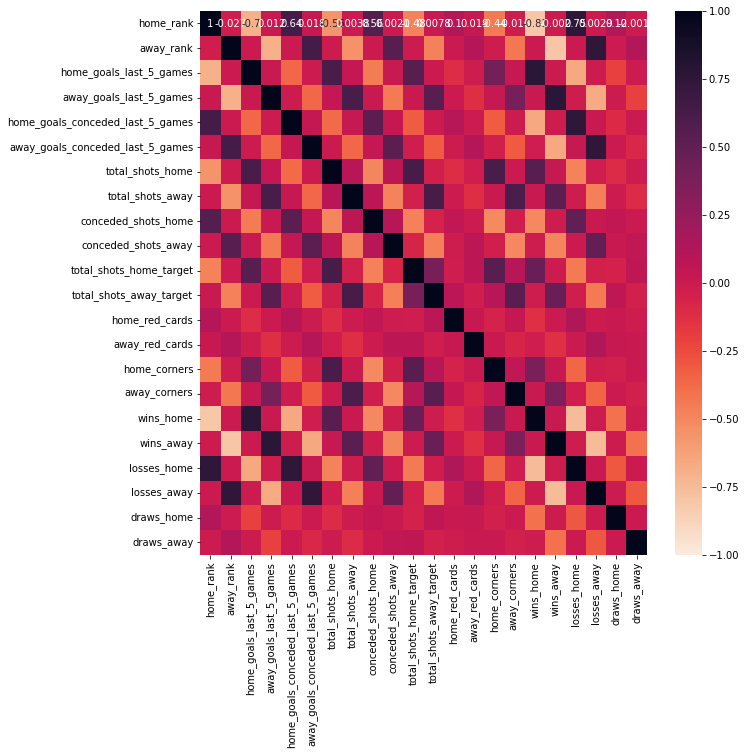

In [37]:
# Plot correlation matrix
plt.figure(figsize=(10, 10))
sns.heatmap(training_df.corr(), vmin=-1, vmax=1, annot=True,cmap="rocket_r")
plt.show()

In [38]:
y = training_df['result']
x = training_df.drop(['result'], axis=1)

x_one_hot = pd.get_dummies(x, columns = ['home', 'away'])
scaler = StandardScaler()
cols = x_one_hot.columns
x_one_hot = scaler.fit_transform(x_one_hot)

In [53]:
x_train, x_test, y_train, y_test = train_test_split(x_one_hot, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_one_hot, y, test_size=0.2, random_state=1)

In [54]:
x_test.shape

(1276, 112)

In [41]:
forest = RandomForestClassifier(n_estimators=400)
forest.fit(x_train, y_train)
y_pred = forest.predict(x_test)
accuracy_score(y_pred, y_test)

0.5415360501567398

In [42]:
f1_score(y_pred, y_test, average='weighted')

0.6077785000136473

<BarContainer object of 112 artists>

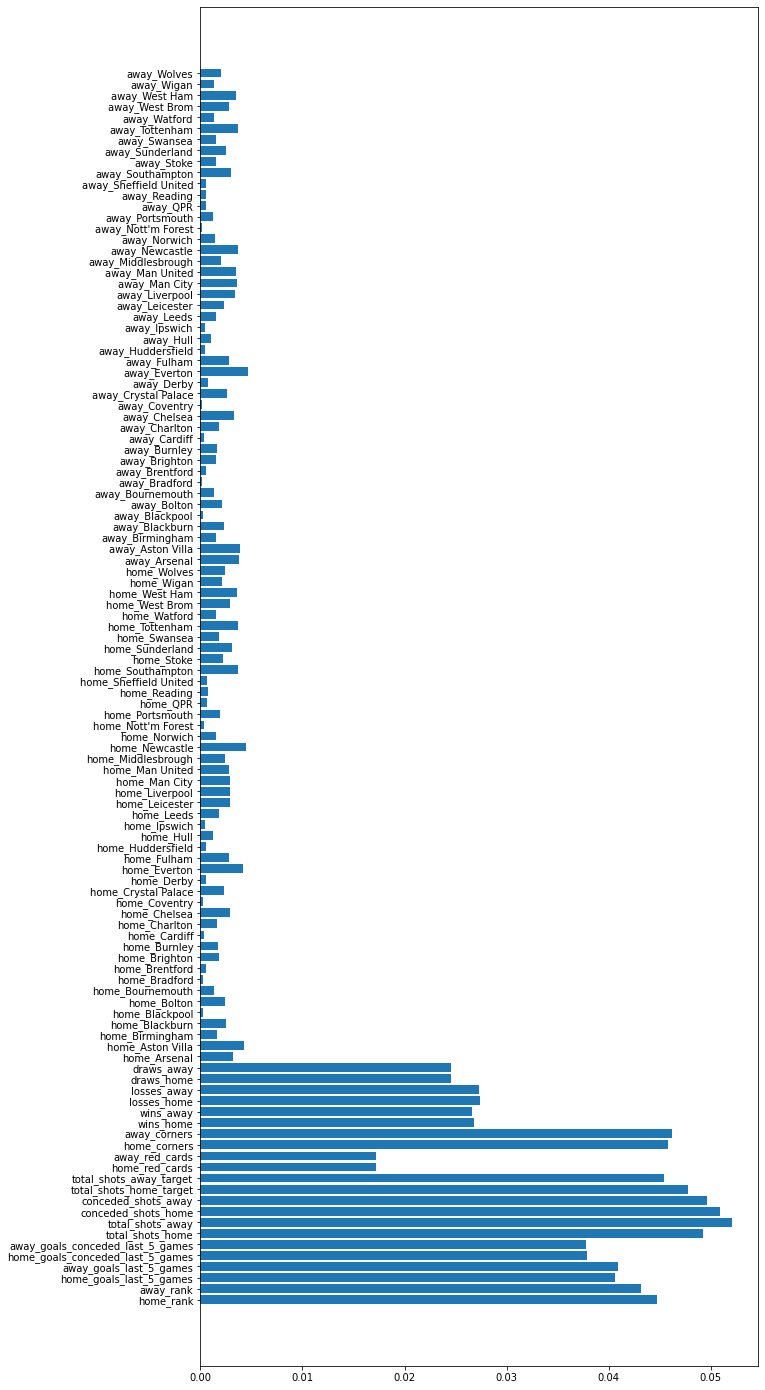

In [43]:
# Feature importance
plt.figure(figsize=(10, 25))
plt.barh(cols, forest.feature_importances_)

# Other models

In [44]:
lr = LogisticRegression(multi_class='multinomial', solver='lbfgs', max_iter=10_000).fit(x_train, y_train)
y_pred = lr.predict(x_test)
accuracy_score(y_pred, y_test)

0.5289968652037618

In [116]:
np.unique(predicted_labels, return_counts=True)

(array(['A', 'H'], dtype=object), array([ 270, 1006]))

In [46]:
clf = svm.SVC()
clf.fit(x_train, y_train)
y_pred = clf.predict(x_test)
accuracy_score(y_pred, y_test)

0.5195924764890282

In [47]:
np.unique(y_pred, return_counts=True)

(array(['A', 'D', 'H'], dtype=object), array([320,  55, 901]))

In [110]:
x_train, x_test, y_train, y_test = train_test_split(x_one_hot, y, test_size=0.2, random_state=1)
x_train, x_val, y_train, y_val = train_test_split(x_one_hot, y, test_size=0.2, random_state=1)

In [111]:
encoder = LabelEncoder()

In [112]:
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
n_classes = 3
# Convert labels to one-hot encoded
y_train = encoder.fit_transform(y_train)
# y_test = encoder.fit_transform(y_test)
y_val = encoder.fit_transform(y_val)


y_train = to_categorical(y_train, num_classes=3)
# y_test = to_categorical(y_test, num_classes=3)
y_val = to_categorical(y_val, num_classes=3)


# Define the model
model = Sequential()
model.add(Dense(256, input_dim=x_train.shape[1], activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.7))
model.add(Dense(n_classes, activation='softmax'))  # Output layer

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
model.fit(x_train, y_train, epochs=50, batch_size=32, validation_data=(x_val, y_val))
predictions = model.predict(x_test)

Epoch 1/50
160/160 [==============================] - 1s 4ms/step - loss: 1.4737 - accuracy: 0.3643 - val_loss: 1.0731 - val_accuracy: 0.4734
Epoch 2/50
160/160 [==============================] - 0s 2ms/step - loss: 1.1421 - accuracy: 0.4049 - val_loss: 1.0679 - val_accuracy: 0.4734
Epoch 3/50
160/160 [==============================] - 0s 2ms/step - loss: 1.0810 - accuracy: 0.4539 - val_loss: 1.0621 - val_accuracy: 0.4734
Epoch 4/50
160/160 [==============================] - 0s 2ms/step - loss: 1.0711 - accuracy: 0.4569 - val_loss: 1.0495 - val_accuracy: 0.4734
Epoch 5/50
160/160 [==============================] - 0s 2ms/step - loss: 1.0616 - accuracy: 0.4669 - val_loss: 1.0400 - val_accuracy: 0.4734
Epoch 6/50
160/160 [==============================] - 0s 2ms/step - loss: 1.0407 - accuracy: 0.4724 - val_loss: 1.0252 - val_accuracy: 0.4922
Epoch 7/50
160/160 [==============================] - 0s 2ms/step - loss: 1.0420 - accuracy: 0.4792 - val_loss: 1.0195 - val_accuracy: 0.4984
Epoch 

In [113]:
predicted_label_indices = np.argmax(predictions, axis=1)
predicted_labels = encoder.inverse_transform(predicted_label_indices)


In [114]:
accuracy_score(predicted_labels, y_test)

0.5509404388714734

In [115]:
predicted_labels

array(['H', 'H', 'H', ..., 'H', 'H', 'H'], dtype=object)